<h1 style = "color:red"><b>Created by Refath Bari</b></h1>

# Install libraries

In [6]:
pip install tensorflow

In [7]:
pip install numpy

In [8]:
pip install matplotlib

In [9]:
!git clone https://github.com/Refath/SinusoidalAnalyzer.git

fatal: destination path 'SinusoidalAnalyzer' already exists and is not an empty directory.


# Import Libraries

In [10]:
# Import Libraries
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

# Load Dataset

In [11]:
import pathlib
dataset_url = "https://barisciencelab.tech/Graphs.tar.gz"
data_dir = tf.keras.utils.get_file(origin = dataset_url,
                                   fname = "FunctionIdentifier",
                                   untar = True)
data_dir = pathlib.Path(data_dir)

1720320/1714614 [==============================] - 0s 0us/step


# Display Num. Images to check

In [12]:
print(list(data_dir.glob('*/*.png')))
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

[PosixPath('/root/.keras/datasets/FunctionIdentifier/SmallCubicSinusoidal/CubicSine_356.png'), PosixPath('/root/.keras/datasets/FunctionIdentifier/SmallCubicSinusoidal/CubicSine_415.png'), PosixPath('/root/.keras/datasets/FunctionIdentifier/SmallCubicSinusoidal/CubicSine_979.png'), PosixPath('/root/.keras/datasets/FunctionIdentifier/SmallCubicSinusoidal/CubicSine_571.png'), PosixPath('/root/.keras/datasets/FunctionIdentifier/SmallCubicSinusoidal/CubicSine_335.png'), PosixPath('/root/.keras/datasets/FunctionIdentifier/SmallCubicSinusoidal/CubicSine_703.png'), PosixPath('/root/.keras/datasets/FunctionIdentifier/SmallCubicSinusoidal/CubicSine_68.png'), PosixPath('/root/.keras/datasets/FunctionIdentifier/SmallCubicSinusoidal/CubicSine_99.png'), PosixPath('/root/.keras/datasets/FunctionIdentifier/SmallCubicSinusoidal/CubicSine_46.png'), PosixPath('/root/.keras/datasets/FunctionIdentifier/SmallCubicSinusoidal/CubicSine_459.png'), PosixPath('/root/.keras/datasets/FunctionIdentifier/SmallCubic

# Display sample image

[PosixPath('/root/.keras/datasets/FunctionIdentifier/SmallCubicSinusoidal/CubicSine_356.png'), PosixPath('/root/.keras/datasets/FunctionIdentifier/SmallCubicSinusoidal/CubicSine_415.png'), PosixPath('/root/.keras/datasets/FunctionIdentifier/SmallCubicSinusoidal/CubicSine_979.png'), PosixPath('/root/.keras/datasets/FunctionIdentifier/SmallCubicSinusoidal/CubicSine_571.png'), PosixPath('/root/.keras/datasets/FunctionIdentifier/SmallCubicSinusoidal/CubicSine_335.png'), PosixPath('/root/.keras/datasets/FunctionIdentifier/SmallCubicSinusoidal/CubicSine_703.png'), PosixPath('/root/.keras/datasets/FunctionIdentifier/SmallCubicSinusoidal/CubicSine_68.png'), PosixPath('/root/.keras/datasets/FunctionIdentifier/SmallCubicSinusoidal/CubicSine_99.png'), PosixPath('/root/.keras/datasets/FunctionIdentifier/SmallCubicSinusoidal/CubicSine_46.png'), PosixPath('/root/.keras/datasets/FunctionIdentifier/SmallCubicSinusoidal/CubicSine_459.png'), PosixPath('/root/.keras/datasets/FunctionIdentifier/SmallCubic

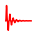

In [13]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
graphs = list(data_dir.glob('*/*.png'))
print(graphs)
PIL.Image.open(str(graphs[6]))

# Define Image Dimensions & Batch Size

In [14]:
batch_size = 32
img_height = 36
img_width = 36

# Create Training & Validation Sets (80%, 20%)

In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 3 classes.
Using 2400 files for training.


In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 3 classes.
Using 600 files for validation.


# Define 3 Classes

In [17]:
class_names = ['Cubic Sinusoidal', 'Linear Sinusoidal', 'Quadratic Sinusoidal']
print(class_names)

['Cubic Sinusoidal', 'Linear Sinusoidal', 'Quadratic Sinusoidal']


# Supervised Learning (9 Samples from the Training Set)

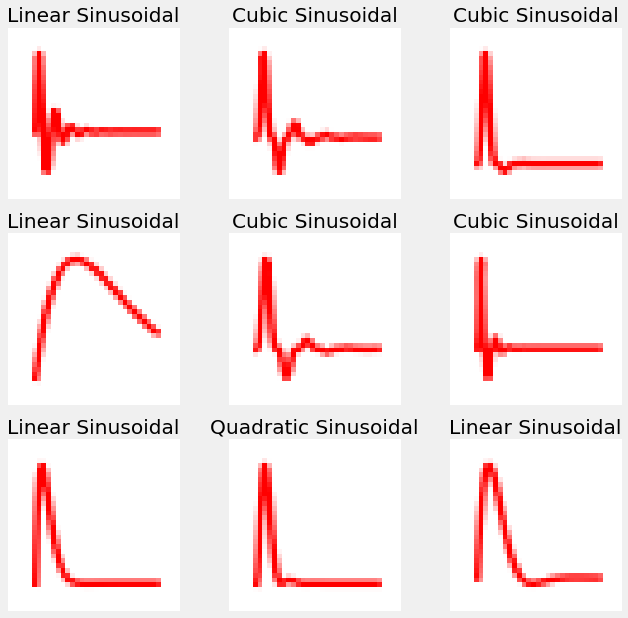

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [19]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 36, 36, 3)
(32,)


# Normalize Inputs (/255px)

In [20]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [21]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Architechture of CNN (3 Conv2Ds, 3 MaxPool2Ds, 2 Dense and Flatten)

In [23]:
num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [24]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [124]:
epochs = 3

initial_learning_rate = 0.01
decay = initial_learning_rate / epochs

def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3,
  callbacks= tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay, verbose=1)
)

Epoch 1/3

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
75/75 [==============================] - 4s 48ms/step - loss: 0.1471 - accuracy: 0.9458 - val_loss: 0.1440 - val_accuracy: 0.9350
Epoch 2/3

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0009966777882034399.
75/75 [==============================] - 4s 48ms/step - loss: 0.1016 - accuracy: 0.9675 - val_loss: 0.0841 - val_accuracy: 0.9717
Epoch 3/3

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0009900772718971732.
75/75 [==============================] - 4s 48ms/step - loss: 0.0698 - accuracy: 0.9775 - val_loss: 0.0617 - val_accuracy: 0.9817


In [125]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 36, 36, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 34, 34, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0

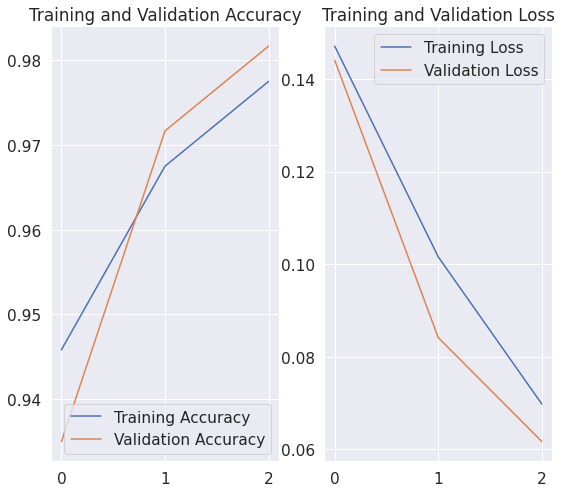

In [126]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 1-Sample *Cubic* Test ( **Passed; Accuracy: 95.99%** )

In [127]:
cubic_url = "https://raw.githubusercontent.com/Refath/SinusoidalAnalyzer/main/CubicSinusoidal_1.png"
cubic_path = tf.keras.utils.get_file('CubicSinusoidal_1', origin=cubic_url)

img = keras.preprocessing.image.load_img(
    cubic_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Cubic Sinusoidal with a 99.74 percent confidence.


# 1-Sample *Quadratic* Test ( **Passed; Accuracy: 99.90%** )

In [128]:
quad_url = "https://raw.githubusercontent.com/Refath/SinusoidalAnalyzer/main/QuadSinusoidal_1.png"
quad_path = tf.keras.utils.get_file('QuadSinusoidal_1', origin=quad_url)

img = keras.preprocessing.image.load_img(
    quad_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Quadratic Sinusoidal with a 100.00 percent confidence.


# 1-Sample *Linear* Test ( **Passed; 99.14%** )

In [129]:
lin_url = "https://raw.githubusercontent.com/Refath/SinusoidalAnalyzer/main/LinSinusoidal_1.png"
lin_path = tf.keras.utils.get_file('LinSinusoidal_1', origin=lin_url)

img = keras.preprocessing.image.load_img(
    lin_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Linear Sinusoidal with a 99.82 percent confidence.


# Image Input Array

In [130]:
pip install glob2

In [96]:
preds = []

for i in range(0,10):

  lin_url = "https://raw.githubusercontent.com/Refath/SinusoidalAnalyzer/main/Toll2/Graph_"+str(i)+".png"
  lin_path = tf.keras.utils.get_file('Graph_'+str(i)+'.png', origin=lin_url)

  img = keras.preprocessing.image.load_img(
      lin_path, target_size=(img_height, img_width)
  )

  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )
  preds.append(np.argmax(score))

print(preds)

8192/617 [==============================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step
This image most likely belongs to Quadratic Sinusoidal with a 87.76 percent confidence.
8192/873 [=========================================================================================================================================================================================================================================================================================] - 0s 0us/step
This image most likely belongs to Linear Sinusoidal with a 88.87 percent confidence.
8192/575 [======================================================================================

# Confusion Matrix

In [97]:
actual = [2, 1, 2, 1, 1, 1, 2, 2, 0, 1]
tf.math.confusion_matrix(preds, actual)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[1, 0, 0],
       [0, 5, 0],
       [0, 0, 4]], dtype=int32)>

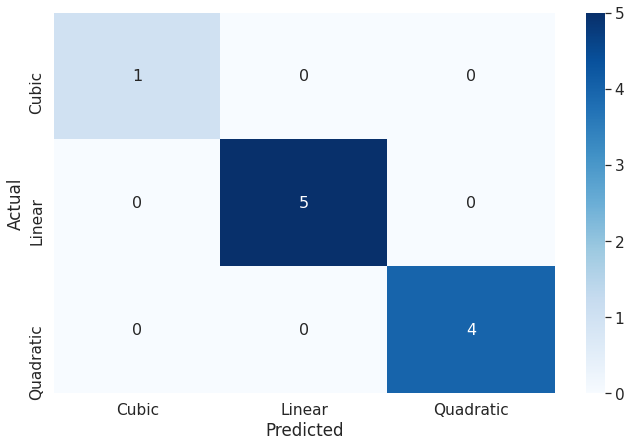

In [119]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

y_true = actual
y_pred = preds
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=['Cubic','Linear','Quadratic'], index = ['Cubic','Linear','Quadratic'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})